In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors, ensemble, kernel_ridge, svm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split


## Load data

In [2]:
# Ignore ORIGIN_CALL and other categorical columns
np.random.seed(42)
# train_arr = np.loadtxt("../data/numeric_trainvf.csv", dtype=np.float32, delimiter=",", skiprows=1)[:, 4:]
df_train = pd.read_csv("../data/combined_trainvf_trig.csv", index_col=0)
df_train.head()
# Prune
df_train = df_train[df_train["DIST"] < 25]
df_train = df_train[df_train["TARGET"] > 30]
df_train = df_train[df_train["TARGET"] < 20000]

# Categorical
df_train["ORIGIN_CALL"] = df_train["ORIGIN_CALL"].astype("category")
df_train["ORIGIN_STAND"] = df_train["ORIGIN_STAND"].astype("category")
df_train["TAXI_ID"] = df_train["TAXI_ID"].astype("category")
df_train["YEAR"] = df_train["YEAR"].astype("category")
df_train["WK_OF_YR"] = df_train["WK_OF_YR"].astype("category")
df_train["WK_DAY"] = df_train["WK_DAY"].astype("category")
df_train["HR"] = df_train["HR"].astype("category")
df_train["MONTH"] = df_train["MONTH"].astype("category")
droplist = ["ORIGIN_CALL",'WK_OF_YR_SIN',
       'WK_OF_YR_COS', 'WK_DAY_SIN', 'WK_DAY_COS', 'MONTH_SIN', 'MONTH_COS',
       'DAY_SIN', 'DAY_COS', 'HR_SIN', 'HR_COS']
df_train.drop(labels=droplist, inplace=True, axis=1)
# Split
train, valid = train_test_split(df_train, test_size=0.1)
train_label = train["TARGET"]
train.drop(labels=["TARGET"], inplace=True, axis=1)
valid_label = valid["TARGET"]
valid.drop(labels=["TARGET"], inplace=True, axis=1)

# Test
# test = np.loadtxt("../data/combined_testvf.csv", delimiter=",", skiprows=1)[:, 3:]
df_test = pd.read_csv("../data/combined_testvf_trig.csv")
# df_test["ORIGIN_CALL"] = df_test["ORIGIN_CALL"].astype("category").cat.set_categories(df_train["ORIGIN_CALL"].cat.categories)
df_test["ORIGIN_STAND"] = df_test["ORIGIN_STAND"].astype("category").cat.set_categories(df_train["ORIGIN_STAND"].cat.categories)
df_test["TAXI_ID"] = df_test["TAXI_ID"].astype("category").cat.set_categories(df_train["TAXI_ID"].cat.categories)
df_test["YEAR"] = df_test["YEAR"].astype("category").cat.set_categories(df_train["YEAR"].cat.categories)
df_test["WK_OF_YR"] = df_test["WK_OF_YR"].astype("category").cat.set_categories(df_train["WK_OF_YR"].cat.categories)
df_test["WK_DAY"] = df_test["WK_DAY"].astype("category").cat.set_categories(df_train["WK_DAY"].cat.categories)
df_test["HR"] = df_test["HR"].astype("category").cat.set_categories(df_train["HR"].cat.categories)
df_test["MONTH"] = df_test["MONTH"].astype("category").cat.set_categories(df_train["MONTH"].cat.categories)
df_test.drop(labels=droplist, inplace=True, axis=1)

/tmp/ipykernel_103/391381445.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(labels=["TARGET"], inplace=True, axis=1)
/tmp/ipykernel_103/391381445.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.drop(labels=["TARGET"], inplace=True, axis=1)


In [83]:
df_test.columns

Index(['ORIGIN_STAND', 'TAXI_ID', 'START_LONG', 'START_LAT', 'A', 'B', 'C',
       'YEAR', 'WK_OF_YR', 'WK_DAY', 'MONTH', 'DAY', 'HR', 'DIST'],
      dtype='object')

In [7]:
def score(model):
    pred = model.predict(valid)
    print(f"RMSE: {np.sqrt(np.sum((pred - valid_label)**2) / len(valid))}")

## Models

### XGBoost

In [86]:
reg_full = xgb.XGBRegressor(tree_method="gpu_hist", n_estimators=50, enable_categorical=True, max_cat_to_onehot=1)
reg_full.fit(train, train_label, sample_weight=train_label)
preds_full = reg_full.predict(df_test)
score(reg_full)

RMSE: 705.6048584179125


In [42]:
# E V E R Y T H I N G
pred = reg_full.predict(valid[valid["A"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['A'] == 1])**2) / len(valid[valid['A'] == 1]))}")
pred = reg_full.predict(valid[valid["B"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['B'] == 1])**2) / len(valid[valid['B'] == 1]))}")
pred = reg_full.predict(valid[valid["C"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['C'] == 1])**2) / len(valid[valid['C'] == 1]))}")

RMSE: 551.6365852644103
RMSE: 527.3901936871165
RMSE: 1012.7738073630297


In [31]:
preds = reg_full.predict(df_test) # No taxi id, origin call, origin stand, no coords
df_pred = pd.read_csv("../data/sampleSubmission.csv")
df_pred["TRAVEL_TIME"] = preds
df_pred.to_csv("./combined_xgboost_all_50_default_TRIG.csv", index=False)

NameError: name 'reg_full' is not defined

### Best public model

In [12]:
reg = xgb.XGBRegressor(tree_method="gpu_hist", n_estimators=4, enable_categorical=True)
reg.fit(train, train_label)
preds = reg.predict(df_test)

In [13]:
print(preds)

[ 636.8959   532.11896  635.8766   532.11896  582.97504  753.14624
  636.8959   664.64716  635.8766   636.8959   532.11896  646.6156
  699.82166 1218.2314   692.4171   927.34985  699.82166 1288.7341
  687.8616   839.9587   636.8959   687.8616   636.8959   700.78503
  532.11896  664.64716  636.8959   687.8616   608.3116   697.1676
  636.8959   532.11896  674.3669   766.9878  1136.0228   646.6156
  662.1067   532.11896  636.8959   562.9479   563.992    646.6156
 1350.6658   636.8959   532.11896  532.11896  646.6156   646.6156
  586.04785  532.11896  757.3739   634.12274  532.11896  660.1102
  697.1676   532.11896  621.1355   577.48267 1017.17487  636.8959
  609.6194   646.6156   699.82166  687.8616   621.1355   636.8959
  636.8959   621.1355   733.37604  516.35864 1055.0509   766.9878
  636.8959   969.7227   512.085    766.9878   512.085    748.61774
  661.8573  1017.67535  592.1429   619.8942   619.8942   650.5705
  512.085    643.88635 1000.84705  643.80707  483.94733  957.34155
  592.

In [11]:
df_pred = pd.read_csv("../data/sampleSubmission.csv")
df_pred["TRAVEL_TIME"] = preds
df_pred.to_csv("./combined_xgboost_noorigincall_4_mctooh_10.csv", index=False)

In [82]:
preds_combined = preds + preds_full / 2

In [83]:
print(preds_combined)

[1276.1924  1090.9568  1170.3938  1024.0698  1133.3923  1313.6172
 1173.5781  1181.8596  1214.4435  1160.9861  1072.5726  1406.6819
 1460.3394  2377.5422  1370.973   1668.2456  1354.3307  2108.3599
 1221.1959  1649.9497  1121.5939  1165.1921  1168.4341  1411.3047
  993.46765 1238.9847  1176.1893  1170.0126  1213.3047  1200.0282
 1128.2544  1056.483   1167.5645  1469.9329  2516.7515  1568.2969
 1399.1887  1121.2574  1270.6532  1684.6573   964.1573  1205.0161
 2829.218   1099.1218  1050.4863  1066.0546  1176.0645  1155.7227
 1265.1001  1053.0219  1402.4852  1287.0151  1067.2312  1231.4438
 1354.5741   991.97314 1105.3911  1133.8948  2101.9087  1132.2039
 1155.8794  1270.4766  1281.3204  1337.2988  1021.7158  1208.3973
 1183.9081  1066.9937  1777.3767   939.1366  2175.3726  1666.7982
 1213.3438  2296.7004   975.7856  1614.7509   882.21277 1919.2567
 1531.1177  1716.667   1096.4426  1097.7395  1186.2424  1169.367
  899.3263  1195.2212  3606.594   1437.0144   886.85474 1364.9995
 1213.333  

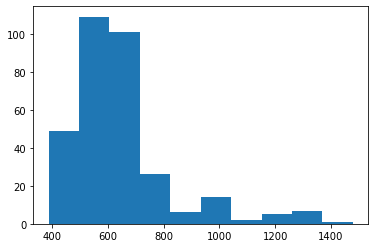

In [67]:
plt.hist(preds)
plt.show()

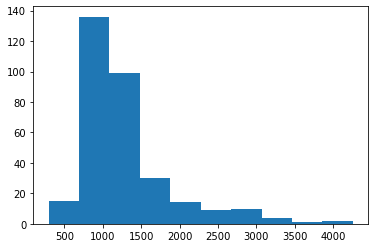

In [66]:
plt.hist(preds_full)
plt.show()

In [54]:
preds = reg.predict(df_test) # No taxi id, origin call, origin stand, no coords
df_pred = pd.read_csv("../data/sampleSubmission.csv")
df_pred["TRAVEL_TIME"] = preds
df_pred.to_csv("./combined_xgboost_all_5_default_15kmax_TRIG.csv", index=False)

In [108]:
# E V E R Y T H I N G
pred = reg.predict(valid[valid["A"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['A'] == 1])**2) / len(valid[valid['A'] == 1]))}")
pred = reg.predict(valid[valid["B"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['B'] == 1])**2) / len(valid[valid['B'] == 1]))}")
pred = reg.predict(valid[valid["C"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['C'] == 1])**2) / len(valid[valid['C'] == 1]))}")

RMSE: 531.4848147987065
RMSE: 464.3774480486925
RMSE: 837.7974275920382


In [8]:
# Yes taxi id, origin call, origin stand, no coords
pred = reg.predict(valid[valid["A"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['A'] == 1])**2) / len(valid[valid['A'] == 1]))}")
pred = reg.predict(valid[valid["B"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['B'] == 1])**2) / len(valid[valid['B'] == 1]))}")
pred = reg.predict(valid[valid["C"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['C'] == 1])**2) / len(valid[valid['C'] == 1]))}")

RMSE: 477.84808351169596
RMSE: 428.91400283658095
RMSE: 786.1901650206082


In [29]:
# simple
pred = reg.predict(valid[valid["A"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['A'] == 1])**2) / len(valid[valid['A'] == 1]))}")
pred = reg.predict(valid[valid["B"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['B'] == 1])**2) / len(valid[valid['B'] == 1]))}")
pred = reg.predict(valid[valid["C"] == 1])
print(f"RMSE: {np.sqrt(np.sum((pred - valid_label[valid['C'] == 1])**2) / len(valid[valid['C'] == 1]))}")

RMSE: 534.2977151110199
RMSE: 463.64833608675974
RMSE: 827.8829632643224


## Create prediction csv

In [9]:
df_pred["TRAVEL_TIME"] = preds
df_pred.to_csv("./combined_xgboost_4_all_notimecategories.csv", index=False)